# Loading Libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style

# Loading the Dataset

In [40]:
# Reading Data # First Column is the index
df = pd.read_csv('../00_Data/Rec_Sys_precleaned.csv', index_col=0)

# First five rows
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID,Gender,...,Income,Zipcode,Customer Segment,Product Name,Description,Category,Brand,Unit Price,Num_word_text,Num_word_cat
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850,female,...,Medium,84306,Middle class,"3 1/2""W x 20""D x 20""H Funston Craftsman Smooth...",Our Rustic Collection is an instant classic. O...,Home Improvement|Hardware|Brackets and Angle I...,Ekena Milwork,199.11,129.0,9.0
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850,female,...,Medium,84306,Middle class,Awkward Styles Shamrock Flag St. Patrick's Day...,Our St Patrick's Day Collection is perfect for...,Clothing|Men|Mens T-Shirts & Tank Tops|Mens Gr...,Awkward Styles,23.95,150.0,7.0
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850,female,...,Medium,84306,Middle class,Ebe Men Black Rectangle Half Rim Spring Hinge ...,Count on EBE for all of your eye correction ne...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,26.99,176.0,5.0
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850,female,...,Medium,84306,Middle class,MightySkins Skin Decal Wrap Compatible with Ap...,Mightyskins are removable vinyl skins for prot...,Electronics|Electronics Learning Center|Ads Fr...,Mightyskins,14.99,118.0,6.0
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850,female,...,Medium,84306,Middle class,awesome since 1948 - 69th birthday gift t-shir...,awesome since 1948 - 69th birthday gift t-shir...,Clothing|Men|Mens T-Shirts & Tank Tops|Mens T-...,Shirtinvaders,49.33,20.0,6.0


In [42]:
# Shape of data
df.shape

(245898, 21)

In [43]:
# Unique Users & Items
print("Unique Users:", df.CustomerID.nunique())
print("Unique Items:", df.StockCode.nunique())

Unique Users: 3011
Unique Items: 2349


# Preparation: Binary Dataset

Main Steps
1. Aggregate all User - Item Interactions & Create Flag Column for Purchases
2. Split into Train & Test Data

## 1. User - Item Aggregation & Flag Column

In [4]:
# Aggregate count of unique User & Item combinations
df_binary = df.groupby(['StockCode', 'CustomerID']).agg({'CustomerID': 'count'})

# Rename Columns 
df_binary.columns = ['purchased']

# Reset Index
df_binary.reset_index(inplace=True)

# Set all purchases to 1 
df_binary['purchased'] = 1 

# Check first five columns
df_binary.head()

,StockCode,CustomerID,purchased
0,10002,12451,1
1,10002,12510,1
2,10002,12583,1
3,10002,12637,1
4,10002,12673,1


In [5]:
# Sanity Check 
df_binary.purchased.describe()

count    172701.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: purchased, dtype: float64

## 2. Split into Train & Test Data

In [6]:
# Load the Python Splitter
from recommenders.datasets.python_splitters import python_stratified_split

In [7]:
# Split into Train & Test 
train, test = python_stratified_split(df_binary, ratio=0.8, filter_by='user', min_rating=10, col_user='CustomerID', col_item='StockCode', seed=1)

In [8]:
# Sanity Check number of unique Users & Items in Train - If numbers differ, this means the stratified split 
print("Users Train: \t",train['CustomerID'].nunique())
print("Items Train: \t",train['StockCode'].nunique())
# Sanity Check number of unique Users & Items in Test
print("Users Test: \t",test['CustomerID'].nunique())
print("Items Test: \t",test['StockCode'].nunique())

Users Train: 	 3011
Items Train: 	 2349
Users Test: 	 3011
Items Test: 	 2307


In [9]:
# Ensure that the same items and users are in both sets 
# Find the set of unique items in both the train and test sets
train_items = set(train['StockCode'].unique())
test_items = set(test['StockCode'].unique())

# Find the intersection of the sets from step 1
common_items = train_items.intersection(test_items)

# Filter the train and test sets to include only the rows with item IDs that are in the intersection set
train = train[train['StockCode'].isin(common_items)]
test = test[test['StockCode'].isin(common_items)]

In [10]:
# Sanity Check number of unique Users & Items in Train
print("Users Train: \t",train['CustomerID'].nunique())
print("Items Train: \t",train['StockCode'].nunique())
# Sanity Check number of unique Users & Items in Test
print("Users Test: \t",test['CustomerID'].nunique())
print("Items Test: \t",test['StockCode'].nunique())

Users Train: 	 3011
Items Train: 	 2307
Users Test: 	 3011
Items Test: 	 2307


In [11]:
# Shapes to Check 
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (137627, 3)
Shape of Test: 	 (34505, 3)


In [12]:
# Save as csv 
train.to_csv('../00_Data/rec_sys_binary_train.csv')
test.to_csv('../00_Data/rec_sys_binary_test.csv')

In [44]:
# Rows aggregated
train.shape[0] + test.shape[0]

172132

# Preparation: Pseudo-Rating Dataset

Main Steps

1. Aggregate all User - Item Interactions & Create Flag Column for Purchases
2. Increase value of repurchased items
3. Insert negative value for non-purchased popular items
4. Split into Train & Test Data

## 1. Aggregate Count of Unique User & Item Interactions

In [46]:
# Aggregate count of unique User & Item combinations
df_ratings = df.groupby(['StockCode', 'CustomerID']).agg({'CustomerID': 'count'})

# Rename the columns
df_ratings.columns = ['purchased']

# Reset the index
df_ratings.reset_index(inplace=True)

# Check first five rows 
df_ratings.head()

,StockCode,CustomerID,purchased
0,10002,12451,1
1,10002,12510,1
2,10002,12583,1
3,10002,12637,1
4,10002,12673,1


In [47]:
# Shape of df_ratings 
df_ratings.shape

(172701, 3)

In [48]:
# How many interaction took place more than once? 
len(df_ratings[df_ratings['purchased']>1])

39191

## 2. Increase Value of Re-Purchased Items

In [49]:
# Apply function with lambda for the condition: If x in purchased <=1 x, else 2 
df_ratings['purchased'] = df_ratings['purchased'].apply(lambda x: x if x <= 1 else 2)

# Check Distribution
df_ratings.purchased.value_counts()

1    133510
2     39191
Name: purchased, dtype: int64

In [50]:
# Check random sample
df_ratings.sample(10)

,StockCode,CustomerID,purchased
25495,21481,12422,1
21237,21287,14414,1
123480,23127,13220,1
44742,21983,17248,1
52949,22138,12624,1
154678,82567,14620,1
95767,22728,17360,1
20934,21259,14895,2
63799,22333,14532,1
88732,22659,15502,2


## 3. Insert negative value for non-purchased popular items

In [51]:
# First Count number of Purchases per Item in the initial Dataset 
df_items = df.groupby('StockCode').agg({'StockCode': 'count'})

# Rename the columns
df_items.columns = ['Purchases']

# Reset the index
df_items.reset_index(inplace=True)

# Show first five rows
df_items.sort_values(by='Purchases', ascending=False).head()

,StockCode,Purchases
2274,85123A,1565
979,22423,1318
1929,47566,1195
2267,85099B,1184
2167,84879,1008


### 3.1. Top 2 Percent

In [52]:
# Filter Out best Items 
df_top2_items = df_items[df_items['Purchases'] >= df_items['Purchases'].quantile(0.98)]

# Number of top Items 
df_top2_items.shape[0]

48

In [53]:
# Save top Items in an array 
top2_perc_items = df_top2_items['StockCode'].unique()

# Save all Users from df_rating in an array
all_users = df_ratings['CustomerID'].unique()

In [54]:
# For sanity check in the next step multiply length of both arrays. This should later be the shape of dataframe with unique combinations out of both arrays
len(top2_perc_items) * len(all_users)

144528

In [55]:
# Create Dataframe with all unique matches of top items and all users 

# First Create a meshgrid of all_users and top5_perc_items
user_grid, item_grid = np.meshgrid(all_users, top2_perc_items, indexing='ij')

# Flatten the meshgrid arrays
user_flat = user_grid.flatten()
item_flat = item_grid.flatten()

# Create a pandas dataframe with a row for each combination of the values in all_users and top5_perc_items
top_potential_purchases = pd.DataFrame({'CustomerID': user_flat, 'StockCode': item_flat})

# Check shape: it should be 144528 
top_potential_purchases.shape

(144528, 2)

In [56]:
# Insert a -1 in a new column as value for all rows
top_potential_purchases['purchased'] = -2 

# Sanity check
top_potential_purchases.head()

,CustomerID,StockCode,purchased
0,12451,20724,-2
1,12451,20726,-2
2,12451,20727,-2
3,12451,20728,-2
4,12451,20914,-2


In [57]:
# Perform an Anti-Join between df_ratings and top_potential_purchases to find out combinations of CustomerID & StockCode that are only in top_potential purchases. Drop duplicates and concatenate to ratings

# Perform the anti join by merging on 'StockCode' and 'CustomerID' using a 'left' join and adding an '_merge' indicator column
popular_non_bought = top_potential_purchases.merge(df_ratings, on=['StockCode', 'CustomerID'], how='left', indicator=True)

# Keep only the rows where the '_merge' indicator is 'left_only', meaning they only exist in the 'df' dataframe
popular_non_bought = popular_non_bought[popular_non_bought['_merge'] == 'left_only']

# Drop the '_merge' column and any additional columns from 'df_cancelled' that might have been added during the merge
popular_non_bought = popular_non_bought.drop(columns=['_merge', 'purchased_y'])

# Reset the index if needed
popular_non_bought.reset_index(drop=True, inplace=True)

# Rename purchased_x to purchased
popular_non_bought = popular_non_bought.rename(columns={'purchased_x':'purchased'})

# Check Shape after Ánti Join
popular_non_bought.shape


(126326, 3)

In [58]:
# Concatenate popular_non_bought with df_ratings
df_ratings = pd.concat([df_ratings, popular_non_bought], ignore_index=True)

# Check sample
df_ratings.sample(10)

,StockCode,CustomerID,purchased
50780,22096,14096,1
87073,22634,16686,2
251823,85123A,18072,-2
179752,22993,18226,-2
87846,22646,12779,2
88769,22659,16693,1
204237,22720,15240,-2
208007,22384,12948,-2
41053,21922,12994,1
167250,85053,14016,1


### 3.2. Top 3-5 Percent

In [59]:
# Filter Out best Items 
df_top_3_5_items = df_items[(df_items['Purchases'] >= df_items['Purchases'].quantile(0.95)) & (df_items['Purchases'] < df_items['Purchases'].quantile(0.98)) ]

# Number of top Items 
df_top_3_5_items.shape[0]

70

In [60]:
# Save top Items in an array 
top3_5_perc_items = df_top_3_5_items['StockCode'].unique()

# Save all Users from df_rating in an array
all_users = df_ratings['CustomerID'].unique()

# For sanity check in the next step multiply length of both arrays. This should later be the shape of dataframe with unique combinations out of both arrays
len(top3_5_perc_items) * len(all_users)

210770

In [61]:
# Create Dataframe with all unique matches of top items and all users 

# First Create a meshgrid of all_users and top5_perc_items
user_grid, item_grid = np.meshgrid(all_users, top3_5_perc_items, indexing='ij')

# Flatten the meshgrid arrays
user_flat = user_grid.flatten()
item_flat = item_grid.flatten()

# Create a pandas dataframe with a row for each combination of the values in all_users and top5_perc_items
top_3_5_potential_purchases = pd.DataFrame({'CustomerID': user_flat, 'StockCode': item_flat})

# Check shape: it should be 144528 
top_3_5_potential_purchases.shape

(210770, 2)

In [62]:
# Insert a -1 in a new column as value for all rows
top_3_5_potential_purchases['purchased'] = -1 

# Sanity check
top_3_5_potential_purchases.head()

,CustomerID,StockCode,purchased
0,12451,20685,-1
1,12451,20712,-1
2,12451,20719,-1
3,12451,20723,-1
4,12451,20972,-1


In [63]:
# Perform an Anti-Join between df_ratings and top_3_5_potential_purchases to find out combinations of CustomerID & StockCode that are only in top_potential purchases. Drop duplicates and concatenate to ratings

# Perform the anti join by merging on 'StockCode' and 'CustomerID' using a 'left' join and adding an '_merge' indicator column
popular_non_bought_3_5 = top_3_5_potential_purchases.merge(df_ratings, on=['StockCode', 'CustomerID'], how='left', indicator=True)

# Keep only the rows where the '_merge' indicator is 'left_only', meaning they only exist in the 'df' dataframe
popular_non_bought_3_5 = popular_non_bought_3_5[popular_non_bought_3_5['_merge'] == 'left_only']

# Drop the '_merge' column and any additional columns from 'df_cancelled' that might have been added during the merge
popular_non_bought_3_5 = popular_non_bought_3_5.drop(columns=['_merge', 'purchased_y'])

# Reset the index if needed
popular_non_bought_3_5.reset_index(drop=True, inplace=True)

# Rename purchased_x to purchased
popular_non_bought_3_5 = popular_non_bought_3_5.rename(columns={'purchased_x':'purchased'})

# Check Shape after Ánti Join
popular_non_bought_3_5.shape


(192977, 3)

In [64]:
# Concatenate popular_non_bought with df_ratings
df_ratings = pd.concat([df_ratings, popular_non_bought_3_5], ignore_index=True)

# Check sample
df_ratings.sample(10)

,StockCode,CustomerID,purchased
188896,21931,12684,-2
458516,22138,13350,-1
390483,82484,14995,-1
95424,22727,15172,1
222518,22423,17802,-2
295918,21181,17096,-2
416564,23208,18027,-1
36762,21843,17697,1
152843,79191C,12716,1
341488,48138,16686,-1


In [65]:
# Check Distribution
df_ratings.purchased.value_counts()

-1    192977
 1    133510
-2    126326
 2     39191
Name: purchased, dtype: int64

In [72]:
# Number of Rows before Split
df_ratings.shape

(492004, 3)

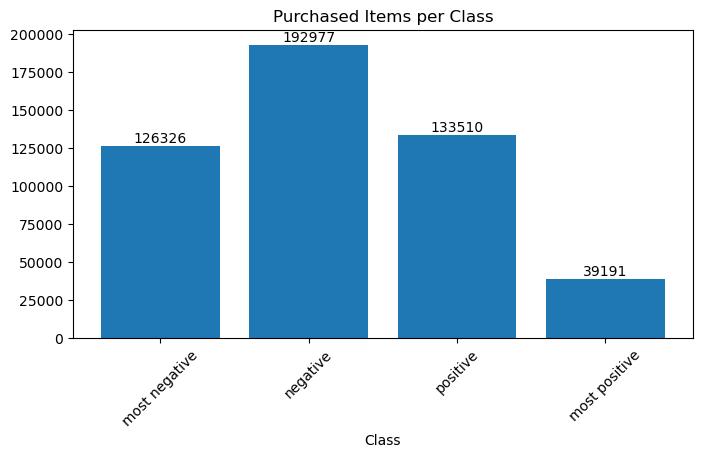

In [74]:
# Visualization 
dist_classes = pd.DataFrame(df_ratings.purchased.value_counts())
dist_classes.reset_index(inplace=True)
dist_classes.columns = ['class', 'purchased']

# Apply function with lambda for the condition:
dist_classes['class'] = dist_classes['class'].apply(lambda x: 4 if x == 2 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 3 if x == 1 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 2 if x == -1 else x)
dist_classes['class'] = dist_classes['class'].apply(lambda x: 1 if x == -2 else x)


import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)

# Create a vertical bar chart
fig, ax = plt.subplots()
bars = ax.bar(dist_classes['class'], dist_classes['purchased'])

# Display the values on the graph
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Class')
#ax.set_ylabel('Purchased')
ax.set_title('Purchased Items per Class')

# Set x-axis ticks with 4 steps from 1 to 4
ax.set_xticks(range(1, 5))

# Create a mapping dictionary for custom labels
class_labels = {
    1: 'most negative',
    2: 'negative',
    3: 'positive',
    4: 'most positive'
}

# Set custom x-axis labels and rotate them by 45 degrees
ax.set_xticklabels([class_labels[i] for i in range(1, 5)], rotation=45)

# Show the plot
plt.show()


## 4. Split into Train & Test Data

In [75]:
# Load Train Test Split 
from sklearn.model_selection import train_test_split
# Split with Stratification 
train_rat, test_rat = train_test_split(df_ratings, stratify=df_ratings.purchased, test_size=0.2)


In [76]:
#  Check number of unique Users & Items in Test & Train 
print("Users in Test:",test_rat['CustomerID'].nunique())
print("Users in Train:",train_rat['CustomerID'].nunique())
print("Items in Test:",test_rat['StockCode'].nunique())
print("Items in Train:",train_rat['StockCode'].nunique())

Users in Test: 3011
Users in Train: 3011
Items in Test: 2318
Items in Train: 2349


In [77]:
# Ensure that the same items and users are in both sets 
# Find the set of unique items in both the train and test sets
train_items_rat = set(train_rat['StockCode'].unique())
test_items_rat = set(test_rat['StockCode'].unique())

# Find the intersection of the sets from step 1
common_items_rat = train_items_rat.intersection(test_items_rat)

# Filter the train and test sets to include only the rows with item IDs that are in the intersection set
train_rat = train_rat[train_rat['StockCode'].isin(common_items_rat)]
test_rat = test_rat[test_rat['StockCode'].isin(common_items_rat)]

In [78]:
#  Check number of unique Users & Items in Test & Train AGAIN
print("Users in Test:",test_rat['CustomerID'].nunique())
print("Users in Train:",train_rat['CustomerID'].nunique())
print("Items in Test:",test_rat['StockCode'].nunique())
print("Items in Train:",train_rat['StockCode'].nunique())

Users in Test: 3011
Users in Train: 3011
Items in Test: 2318
Items in Train: 2318


In [79]:
# Rows in Train & Test
print("Rows in train:", train_rat.shape[0])
print("Rows in test:", test_rat.shape[0])

Rows in train: 393208
Rows in test: 98401


In [82]:
train_rat.shape[0] + test_rat.shape[0]

491609

In [80]:
# Save as csv 
train_rat.to_csv('../00_Data/rec_sys_ratings_train.csv')
test_rat.to_csv('../00_Data/rec_sys_ratings_test.csv')

[Text(0.5, 0, 'ratings'), Text(0, 0.5, 'density')]

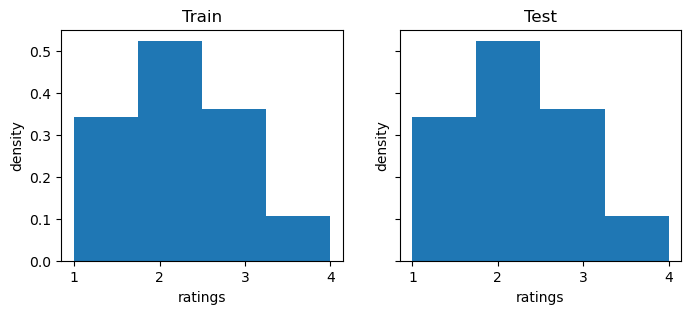

In [81]:
# Copy Train and Test 
train_rat_copy = train_rat.copy()
test_rat_copy = test_rat.copy() 

# Change values for Train
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 4 if x == 2 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 3 if x == 1 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 2 if x == -1 else x)
train_rat_copy['purchased'] = train_rat_copy['purchased'].apply(lambda x: 1 if x == -2 else x) 

# Change values for Test 
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 4 if x == 2 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 3 if x == 1 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 2 if x == -1 else x)
test_rat_copy['purchased'] = test_rat_copy['purchased'].apply(lambda x: 1 if x == -2 else x) 

# Density Histogram
_, (ax1m, ax2m) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1m.hist(train_rat_copy['purchased'], 4, density= True)
ax1m.set_title('Train')
ax1m.set(xlabel="ratings", ylabel="density")
ax2m.hist(test_rat_copy['purchased'], 4, density= True)
ax2m.set_title('Test')
ax2m.set(xlabel="ratings", ylabel="density")